In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load pickles

file = open('final_df_pickle_v1.0', 'rb')
final_df = pickle.load(file)
file.close()

file = open('actor_bday_v1.0', 'rb')
final_df = pickle.load(file)
file.close()

In [3]:
# Adjust datatypes
to_numeric_cols = ['budget','imdb_rating','meta_rating','runtime','usa_gross']
for i in to_numeric_cols:
    final_df[i] = pd.DataFrame(final_df[i], dtype='float')
final_df['year'] = pd.DataFrame(final_df['year'], dtype='int')

# Add interesting columns

final_df['profit'] = final_df['usa_gross'] - final_df['budget']
final_df['log_usa_gross'] = np.log(list(final_df['usa_gross']))
final_df['log_budget'] = np.log(list(final_df['budget']))
final_df['gross_budget_ratio'] = final_df['usa_gross'] / final_df['budget']
final_df['log_gb_ratio'] = np.log(list(final_df['gross_budget_ratio']))
final_df['log_gb_diff'] = final_df['log_usa_gross'] - final_df['log_budget']

quant_cols = ['log_gb_ratio','num_critics','meta_rating','runtime','year']

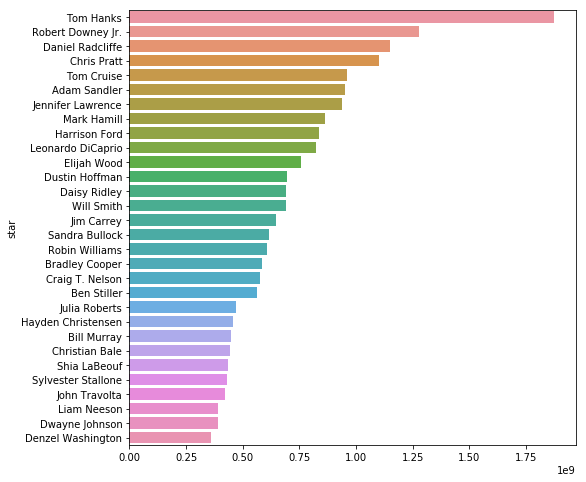

In [4]:
# Best/Worst Actors (Sum over Career)

star_profit = final_df.groupby(by=['star','year']).sum()['profit']
career_star_profit = star_profit.groupby(by='star').sum().sort_values(ascending=False)[0:30]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

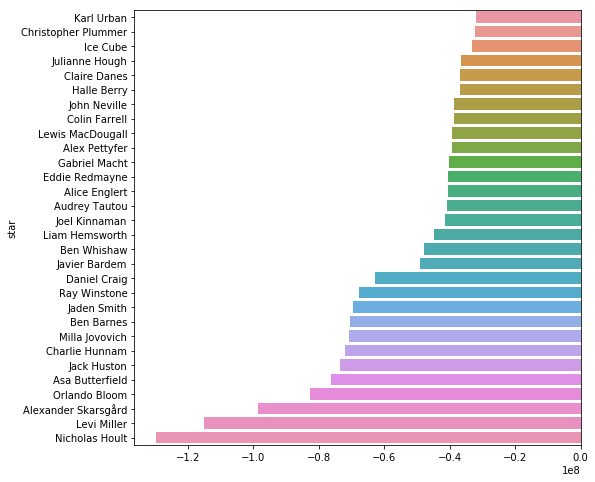

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[-30:]
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

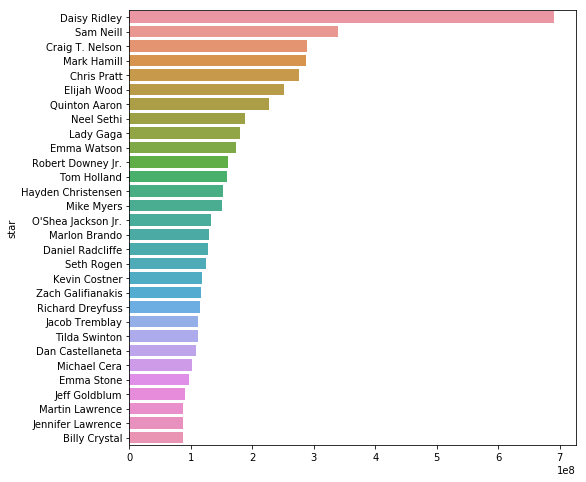

In [6]:
# Best/Worst Actors (Mean over Career)

star_profit = final_df.groupby(by=['star','year']).mean()['profit']
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[0:30]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

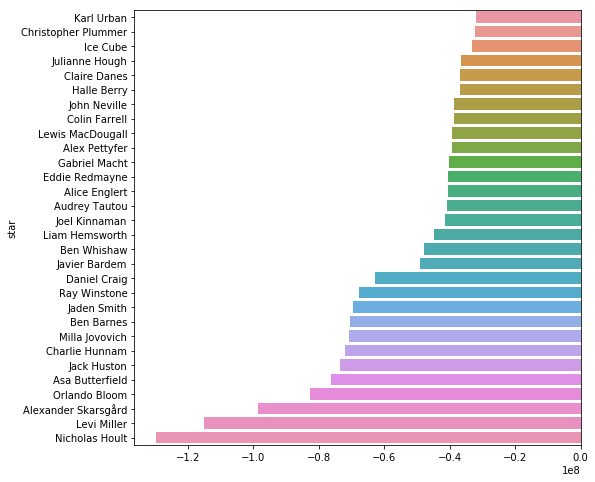

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[-30:]
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

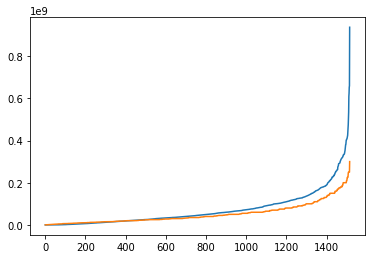

In [8]:
sorted_gross = list(final_df['usa_gross'].sort_values(ascending=True))
sorted_budget = list(final_df['budget'].sort_values(ascending=True))
plt.plot(sorted_gross)
plt.plot(sorted_budget);

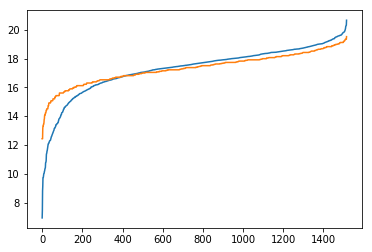

In [9]:
sorted_gross = list(final_df['log_usa_gross'].sort_values(ascending=True))
sorted_budget = list(final_df['log_budget'].sort_values(ascending=True))
plt.plot(sorted_gross)
plt.plot(sorted_budget);

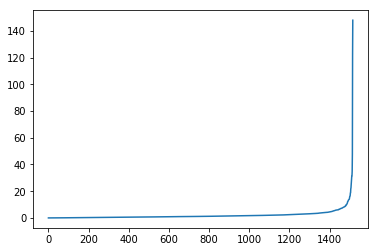

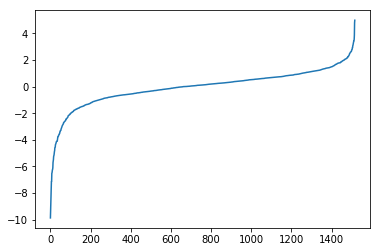

In [11]:
sorted_gb_ratio = list(final_df['gross_budget_ratio'].sort_values(ascending=True))
sorted_log_gb_ratio = list(final_df['log_gb_ratio'].sort_values(ascending=True))
sorted_log_gb_ratio = list(final_df['log_gb_ratio'].sort_values(ascending=True))

plt.plot(sorted_gb_ratio)
plt.show()
plt.plot(sorted_log_gb_ratio);

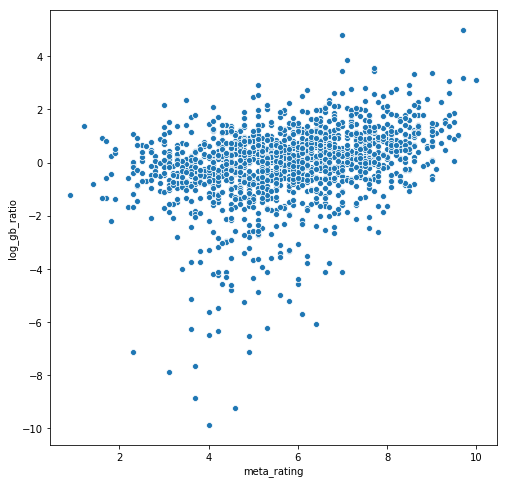

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='meta_rating', y='log_gb_ratio', data=final_df);

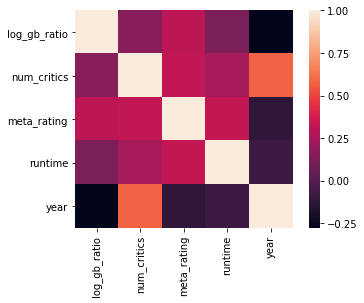

In [14]:
quant_df = final_df[quant_cols].copy()
quant_df = pd.DataFrame(quant_df, dtype='float')
corrs = quant_df.corr()

sns.heatmap(corrs, square=True);

In [15]:
corrs

,log_gb_ratio,num_critics,meta_rating,runtime,year
log_gb_ratio,1.000000,0.156960,0.318420,0.123323,-0.277999
num_critics,0.156960,1.000000,0.329727,0.246422,0.577139
meta_rating,0.318420,0.329727,1.000000,0.333899,-0.117178
runtime,0.123323,0.246422,0.333899,1.000000,-0.072724
year,-0.277999,0.577139,-0.117178,-0.072724,1.000000
